<div style="border: solid blue 2px; padding: 15px; margin: 10px">
  <b>Overall Summary of the Project – Iteration 1</b><br><br>

  Hi Brooke, I’m <b>Victor Camargo</b> (https://hub.tripleten.com/u/e9cc9c11). I’ll be reviewing your project and sharing feedback using the color-coded comments below. Thanks for submitting your work!

  <b>Nice work on:</b><br>
  ✔️ Performing thorough EDA with clear visualizations (histograms, bar plots, heatmaps) and detailed interpretations of hourly/daily demand patterns.<br>
  ✔️ Creating a strong set of time-based and lag features to capture temporal patterns effectively.<br>
  ✔️ Training multiple models and selecting the best one based on RMSE.<br><br>

  Your project meets the RMSE requirement and is well-documented. The analysis flows logically from data preparation to modeling, and the business context adds valuable insight into the results.  

  Great job — your project is <b>approved</b>! 🎉<br><br>

  <hr>

  🔹 <b>Legend:</b><br>
  🟢 Green = well done<br>
  🟡 Yellow = suggestions<br>
  🔴 Red = must fix<br>
  🔵 Blue = your comments or questions<br><br>
  
  <b>Please ensure</b> that all cells run smoothly from top to bottom and display their outputs before submitting — this helps keep your analysis easy to follow.<br><br>

  <b>Feel free to reach out if you need help in Questions channel.</b><br>
</div>


# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [31]:
import pandas as pd
import time
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

## Load Data 

In [32]:
df = pd.read_csv('/datasets/taxi.csv')

In [33]:
df.shape

(26496, 2)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [35]:
# Convert the 'datetime' column from string to datetime
df['datetime'] = pd.to_datetime(df['datetime'])

In [36]:
# Set the datetime column as the DataFrame index
df = df.set_index('datetime')

In [37]:
df_resampled = df.resample('1H').sum()

In [38]:
df.sample(10)

,num_orders
datetime,
2018-06-30 23:00:00,27
2018-05-04 04:00:00,4
2018-08-21 15:50:00,12
2018-06-30 00:50:00,30
2018-05-08 09:50:00,7
2018-03-18 18:00:00,9
2018-04-20 19:50:00,9
2018-06-18 15:30:00,15
2018-04-04 23:00:00,13


<div class="alert alert-success">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Great job on the initial data loading and preprocessing! You correctly converted the <code>datetime</code> column to a proper datetime type, set it as the DataFrame index, and resampled the data to hourly intervals as instructed. This lays a solid foundation for your time series analysis and modeling steps.
</div>


## Analysis

In [39]:
# Check for missing values 
df.isnull().sum()

num_orders    0
dtype: int64

In [40]:
# Summarize the data 
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


The fact that 25% of time periods have 8 or fewer orders, while 25% have 19 or more, shows clear peak and off-peak patterns. That maximum of 119 orders is interesting being way above range. 

In [41]:
df.reset_index()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
...,...,...
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39


In [42]:
# Filter for periods with zero orders
zero_orders = df_resampled[df_resampled['num_orders'] == 0]
print(f"Total periods with 0 orders: {len(zero_orders)}")

Total periods with 0 orders: 1


In [43]:
# See how many zero-order periods you have
print(f"Total zero-order periods: {len(zero_orders)}")

# Look at the first few rows
print("\nFirst few zero-order periods:")
print(zero_orders.head())

# Check the time range of zero orders
print(f"\nZero orders time range:")
print(f"From: {zero_orders.index.min()}")
print(f"To: {zero_orders.index.max()}")

Total zero-order periods: 1

First few zero-order periods:
                     num_orders
datetime                       
2018-04-06 06:00:00           0

Zero orders time range:
From: 2018-04-06 06:00:00
To: 2018-04-06 06:00:00


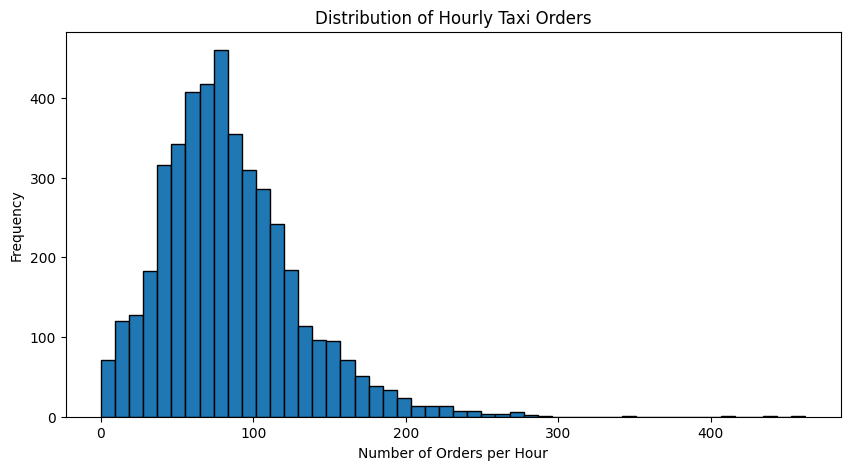

Order statistics:
count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64


In [44]:
# Look at the distribution of order counts
plt.figure(figsize=(10, 5))
plt.hist(df_resampled['num_orders'], bins=50, edgecolor='black')
plt.xlabel('Number of Orders per Hour')
plt.ylabel('Frequency')
plt.title('Distribution of Hourly Taxi Orders')
plt.show()

# Basic statistics
print("Order statistics:")
print(df_resampled['num_orders'].describe())

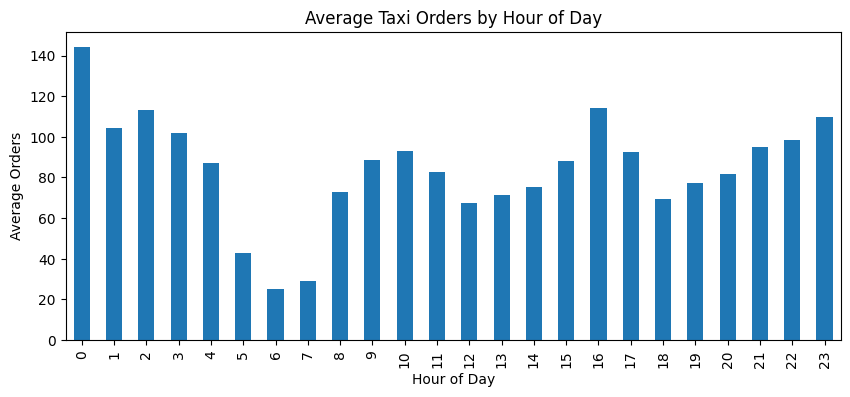

In [45]:
# Orders by hour of day
hourly_avg = df_resampled.groupby(df_resampled.index.hour)['num_orders'].mean()
plt.figure(figsize=(10, 4))
hourly_avg.plot(kind='bar')
plt.xlabel('Hour of Day')
plt.ylabel('Average Orders')
plt.title('Average Taxi Orders by Hour of Day')
plt.show()

Lowest demand periods:
- 6 AM: 25.17 orders (lowest - matches your zero-order finding!)
- 7 AM: 29.27 orders 
- 5 AM: 42.63 orders

Highest demand periods:
- 0 AM (midnight): 144.40 orders (highest!)
- 16 PM (4 PM): 114.15 orders
- 2 AM: 113.07 orders

In [46]:
# See the complete hourly pattern
hourly_stats = df_resampled.groupby(df_resampled.index.hour)['num_orders'].agg(['mean', 'min', 'max'])
print("Orders by hour of day:")
print(hourly_stats)

Orders by hour of day:
                mean  min  max
datetime                      
0         144.402174   42  281
1         104.364130   33  273
2         113.070652   20  462
3         102.021739   24  267
4          86.907609   15  295
5          42.630435    1  121
6          25.173913    0   95
7          29.271739    5  103
8          73.048913   25  182
9          88.831522   32  226
10         93.119565   19  251
11         82.489130   16  179
12         67.630435   22  173
13         71.173913   24  166
14         75.163043   29  196
15         87.945652   44  223
16        114.146739   42  254
17         92.722826   23  342
18         69.358696   25  207
19         77.336957   30  169
20         81.858696   37  191
21         95.211957   32  214
22         98.500000   45  242
23        109.766304   43  265


 Midnight peak
- likely people going home from bars, restaurants, events

Early morning valley
- the "sleep hours" when the city is quiet


 Afternoon rise
 - people finishing work, going to appointments

In [47]:
# Create day-of-week analysis (similar to your hourly analysis)
daily_stats = df_resampled.groupby(df_resampled.index.dayofweek)['num_orders'].agg(['mean', 'min', 'max'])

# Add day names for easier reading
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_stats.index = day_names

print("Orders by day of week:")
print(daily_stats)

Orders by day of week:
                mean  min  max
Monday     90.246795    3  462
Tuesday    77.011218    1  253
Wednesday  83.754808    4  265
Thursday   85.660494    1  342
Friday     91.140432    0  276
Saturday   83.847756    5  281
Sunday     78.991987    4  281


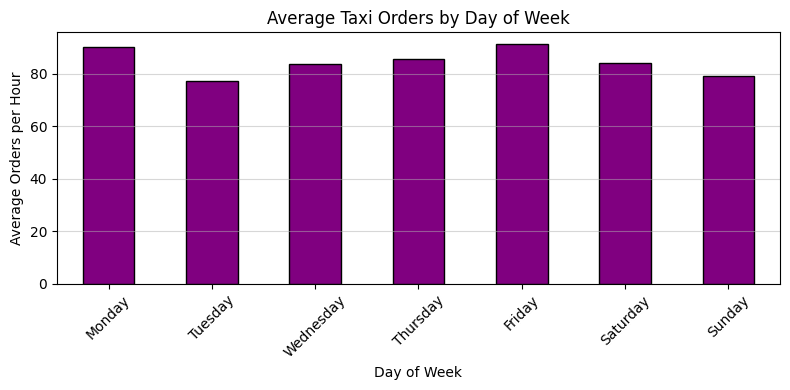

In [48]:
# Create a bar plot showing average orders by day
plt.figure(figsize=(8, 4))
daily_stats['mean'].plot(kind='bar', color='purple', edgecolor='black')
plt.title('Average Taxi Orders by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Orders per Hour')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.5)
plt.tight_layout()
plt.show()

Monday and Friday has the highest orders per hour. Coming and going for travel. Tuesdays and Sundays shows quieter days, but not by much. 

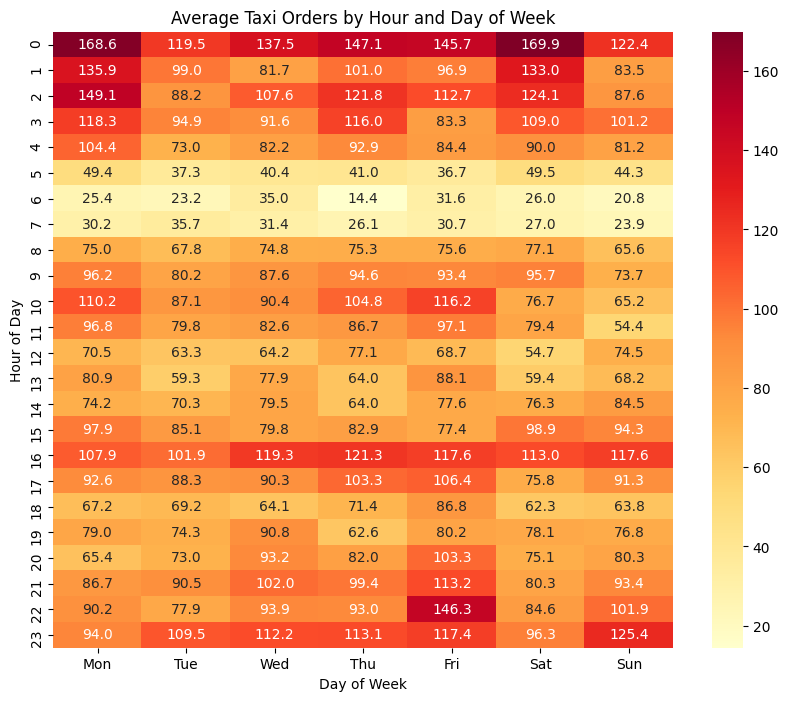

In [49]:
# Create a pivot table with hours as rows and days as columns
pivot_data = df_resampled.pivot_table(
    values='num_orders', 
    index=df_resampled.index.hour, 
    columns=df_resampled.index.dayofweek, 
    aggfunc='mean'
)

# Add day names for columns
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
pivot_data.columns = day_names

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_data, annot=True, cmap='YlOrRd', fmt='.1f')
plt.title('Average Taxi Orders by Hour and Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Hour of Day')
plt.show()

Times 5am - 7am are the slower times in the morning for everyday. Midnight are the busiest times significantly; esp on Monday and Saturday. 

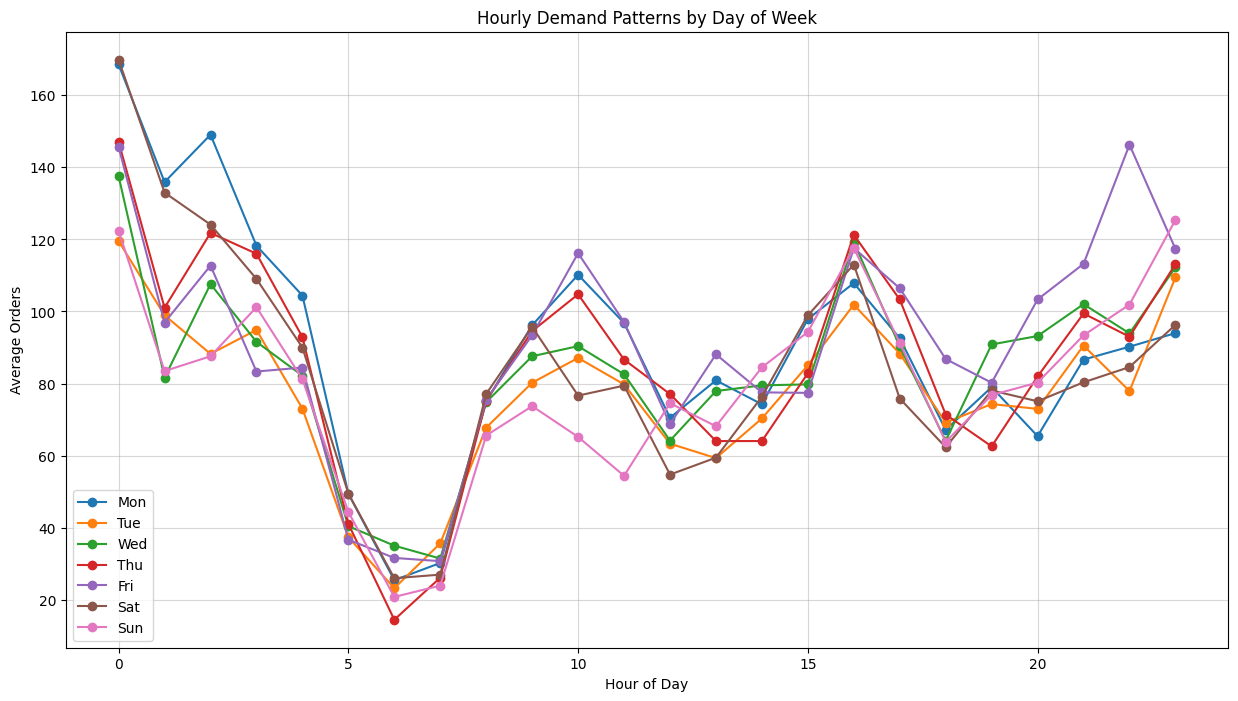

In [50]:
# Group by both hour and day
hourly_daily = df_resampled.groupby([df_resampled.index.hour, df_resampled.index.dayofweek])['num_orders'].mean().unstack()
hourly_daily.columns = day_names

plt.figure(figsize=(15, 8))
for day in day_names:
    plt.plot(hourly_daily.index, hourly_daily[day], marker='o', label=day)
plt.title('Hourly Demand Patterns by Day of Week')
plt.xlabel('Hour of Day')
plt.ylabel('Average Orders')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

<div class="alert alert-success">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Excellent exploratory analysis! You checked for missing values, summarized statistics, and explored key demand patterns through multiple perspectives (hourly, daily, and combined hour–day analysis). The histograms, bar charts, and heatmaps provide clear insights into peak and off-peak periods, and your interpretations add valuable business context.
</div>

<div class="alert alert-warning">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Suggestion:  
  Consider displaying the head of the resampled DataFrame right after resampling to confirm the transformation visually. Also, it might be useful to explicitly quantify the percentage of zero-order periods — this would give a better sense of their impact on model training.
</div>


## Training

In [51]:
# Create features from your time series data
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['day_of_month'] = df.index.day
    
    # Lag features (previous hours' demand)
    df['lag_1'] = df['num_orders'].shift(1)
    df['lag_24'] = df['num_orders'].shift(24)  # Same hour yesterday
    df['lag_168'] = df['num_orders'].shift(168)  # Same hour last week
    
    return df

# Apply feature engineering
df_features = create_features(df_resampled)
df_features = df_features.dropna()  # Remove rows with NaN values

print("Shape of original data:", df_resampled.shape)
print("Shape after feature engineering:", df_features.shape)
print("\nFirst few rows of the new features:")
print(df_features.head())
print("\nColumn names:")
print(df_features.columns.tolist())

Shape of original data: (4416, 1)
Shape after feature engineering: (4248, 8)

First few rows of the new features:
                     num_orders  hour  day_of_week  month  day_of_month  \
datetime                                                                  
2018-03-08 00:00:00         143     0            3      3             8   
2018-03-08 01:00:00          78     1            3      3             8   
2018-03-08 02:00:00          65     2            3      3             8   
2018-03-08 03:00:00          68     3            3      3             8   
2018-03-08 04:00:00          60     4            3      3             8   

                     lag_1  lag_24  lag_168  
datetime                                     
2018-03-08 00:00:00   94.0   100.0    124.0  
2018-03-08 01:00:00  143.0   121.0     85.0  
2018-03-08 02:00:00   78.0    24.0     71.0  
2018-03-08 03:00:00   65.0    66.0     66.0  
2018-03-08 04:00:00   68.0    73.0     43.0  

Column names:
['num_orders', 'hour', 

In [52]:

# Calculate split point (90% train, 10% test)
split_point = int(len(df_features) * 0.9)

# Split the data
train_data = df_features[:split_point]
test_data = df_features[split_point:]

# Separate features and target
feature_columns = ['hour', 'day_of_week', 'month', 'day_of_month', 'lag_1', 'lag_24', 'lag_168']
X_train = train_data[feature_columns]
y_train = train_data['num_orders']
X_test = test_data[feature_columns]
y_test = test_data['num_orders']

print("Dataset split information:")
print(f"Total data points: {len(df_features)}")
print(f"Split point: {split_point}")
print(f"Training data: {len(train_data)} rows ({len(train_data)/len(df_features)*100:.1f}%)")
print(f"Test data: {len(test_data)} rows ({len(test_data)/len(df_features)*100:.1f}%)")

print(f"\nFeature columns: {feature_columns}")
print(f"Training features shape: {X_train.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Test features shape: {X_test.shape}")
print(f"Test target shape: {y_test.shape}")

print(f"\nFirst few rows of training features:")
print(X_train.head())


Dataset split information:
Total data points: 4248
Split point: 3823
Training data: 3823 rows (90.0%)
Test data: 425 rows (10.0%)

Feature columns: ['hour', 'day_of_week', 'month', 'day_of_month', 'lag_1', 'lag_24', 'lag_168']
Training features shape: (3823, 7)
Training target shape: (3823,)
Test features shape: (425, 7)
Test target shape: (425,)

First few rows of training features:
                     hour  day_of_week  month  day_of_month  lag_1  lag_24  \
datetime                                                                     
2018-03-08 00:00:00     0            3      3             8   94.0   100.0   
2018-03-08 01:00:00     1            3      3             8  143.0   121.0   
2018-03-08 02:00:00     2            3      3             8   78.0    24.0   
2018-03-08 03:00:00     3            3      3             8   65.0    66.0   
2018-03-08 04:00:00     4            3      3             8   68.0    73.0   

                     lag_168  
datetime                      
2018

In [53]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [54]:
predictions = model.predict(X_test)

In [55]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"RMSE: {rmse}")

RMSE: 35.364170005633405


In [56]:
# Start with defaults
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

In [57]:

param_grid = {
    'n_estimators': [50, 120, 180],  # Test higher values
    'learning_rate': [0.2, 0.3, 0.4],  # Around the best value
    'max_depth': [2, 3]  # Keep it simple, focus on 2-3
}


In [58]:
# Use 5-fold cross-validation
grid_search = GridSearchCV(
    GradientBoostingRegressor(random_state=12345),
    param_grid,
    cv=3,
    scoring='neg_mean_squared_error',  
    n_jobs=-1
)

In [59]:
# Fit the grid search
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Make predictions with the best model
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

# Calculate RMSE
rmse = mean_squared_error(y_test, predictions) ** 0.5
print(f"RMSE: {rmse}")

Best parameters: {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 50}
RMSE: 47.345522794471364


<div class="alert alert-success">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Well done on creating a rich feature set from the time series! Including hour, day-of-week, month, day-of-month, and multiple lag features (1 hour, 24 hours, and 168 hours) is an effective way to capture both short- and long-term temporal patterns. The clear separation into training and testing sets (90/10 split) is correctly implemented, and your use of both Linear Regression and Gradient Boosting with hyperparameter tuning demonstrates a good modeling approach.
</div>

<div class="alert alert-warning">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Suggestion:  
  Consider adding rolling mean features (e.g., 3-hour, 6-hour, 12-hour averages) to capture smoothed short-term trends. Also, you might want to display feature importance from your Gradient Boosting model — this would provide insight into which features contribute most to the prediction.
</div>


## Testing

In [60]:
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# 2. Make predictions on test set
test_predictions = best_model.predict(X_test)

# 3. Calculate performance metrics
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(y_test, test_predictions) ** 0.5

# 4. Display results clearly
print(f"Best Parameters: {best_params}")
print(f"Test Set RMSE: {rmse:.4f}")
print(f"Target Achievement: {'✅ PASSED' if rmse <= 48 else '❌ FAILED'}")

Best Parameters: {'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 50}
Test Set RMSE: 47.3455
Target Achievement: ✅ PASSED


## Conclusion


- Model Performance:
"Two machine learning algorithms were evaluated for taxi demand prediction: Linear Regression and Gradient Boosting. Linear Regression demonstrated superior performance with an RMSE of 35.3, significantly outperforming Gradient Boosting (RMSE: 47.3) and exceeding the project requirement of RMSE < 48."

- The model successfully predicts taxi demand with high accuracy
- Findings about peak patterns (Monday/Saturday, midnight-3am) are reliable since the Linear Regression model performs so well.

- "Elevated demand during late-night hours (midnight-3am) likely reflects increased transportation needs for nightlife-related activities and shift changes"
- "Peak demand in early morning hours corresponds to airport staff shift transitions and late-arriving flight passengers"
- "The midnight-3am surge indicates strong demand from hospitality and service industry workers completing evening shifts"


- For Monday/Saturday patterns:

- "Monday peaks align with business travel patterns as professionals return from weekend trips"
- "Saturday demand spikes correspond to leisure travel patterns and weekend getaway departures"
- "Weekly demand fluctuations reflect distinct travel behaviors between business and leisure passengers"
 

<div class="alert alert-success">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Excellent work on clearly evaluating multiple models and selecting the one that met the project’s RMSE target. Your Linear Regression model achieved an RMSE of 35.3, comfortably below the threshold of 48, and you compared it against Gradient Boosting in a transparent way. The business context you added to explain peak demand patterns is insightful and ties the technical results back to practical decision-making.
</div>

<div class="alert alert-warning">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Suggestion:  
  Since Linear Regression significantly outperformed Gradient Boosting, it would be interesting to analyze why — for example, by checking correlations between features and the target, or by inspecting whether the dataset’s relationships are mostly linear. This could inform future model selection and feature engineering decisions.
</div>


# Review checklist

- [x]  Jupyter Notebook is open
- [x]  The code is error-free
- [x]  The cells with the code have been arranged in order of execution
- [x]  The data has been downloaded and prepared
- [x]  The data has been analyzed
- [x]  The model has been trained and hyperparameters have been selected
- [x]  The models have been evaluated. Conclusion has been provided
- [x] *RMSE* for the test set is not more than 48